In [3]:
import pytorch_lightning as pl
import cellseg_models_pytorch as csmp
from pathlib import Path
from cellseg_models_pytorch.datamodules import LizardDataModule
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from cellseg_models_pytorch.training.lit import SegmentationExperiment
import warnings

In [4]:
# Settings
warnings.filterwarnings('ignore')
DATA_PATH = './data/benchmarks/'
CKPT_PATH = './data/checkpoints/'
DATA_PATH = Path(DATA_PATH)
LIZARD_PATH = DATA_PATH / 'lizard'

In [5]:
def prepare_lizard_data():
    """Prepare lizard data for training, validation, and testing."""
    fold_split = {"train": 1, "valid": 2, "test": 3}
    lizard_module = LizardDataModule(
        save_dir=LIZARD_PATH,
        fold_split=fold_split,
        inst_transforms=["cellpose"],
        img_transforms=["blur", "hue_sat"],
        patch_size=(320, 320),
        stride=220,
        normalization="minmax",
    )
    lizard_module.prepare_data()
    return lizard_module

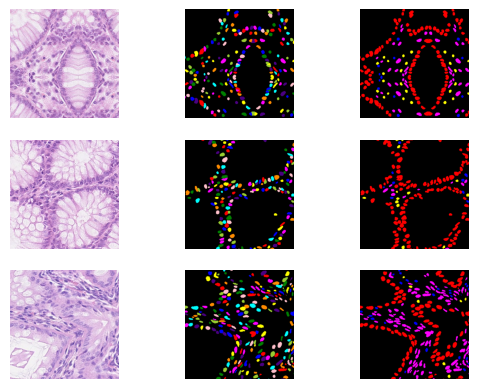

In [6]:
def plot_lizard_data_samples(img_dir, mask_dir, indices):
    """Plot Lizard data sample"""
    imgs = sorted(img_dir.glob("*"))
    masks = sorted(mask_dir.glob("*"))
    fig, axes = plt.subplots(3, len(indices)) 
    for idx, indice in enumerate(indices):
        img = csmp.utils.FileHandler.read_img(imgs[indice])
        mask = csmp.utils.FileHandler.read_mat(masks[indice], return_all=True)
        axes[idx, 0].imshow(img)
        axes[idx, 1].imshow(label2rgb(mask["inst_map"], bg_label=0))
        axes[idx, 2].imshow(label2rgb(mask["type_map"], bg_label=0))
    for ax in axes.flatten():
        ax.set_axis_off()
    return fig

_ = plot_lizard_data_samples(
    LIZARD_PATH / "train" / "train_im_patches",
    LIZARD_PATH / "train" / "train_mask_patches",
    [0, 50, 300]
)

In [7]:
def get_cellpose_model(enc_name, num_classes):
    """Get cellpose model
    enc_name (str): name of encoder. e.g. -> "tf_efficientnetv2_s"
    num_classes (int): number of classes. e.g. -> len(lizard_module.type_classes)
    """
    model = csmp.models.cellpose_base(
        enc_name=enc_name,
        type_classes=num_classes,
    )
    return model

def get_seg_experiment(model):
    experiment = SegmentationExperiment(
        model=model,
        branch_losses={"cellpose": "ssim_mse", "type": "tversky_focal"},
        branch_metrics={"cellpose": [None], "type": ["miou"]},
        optimizer="adamw",
    )
    return experiment

def get_trainer(max_epochs=10):
    trainer = pl.Trainer(
        accelerator="gpu",
        max_epochs=max_epochs,
        move_metrics_to_cpu=True,
    )
    return trainer

def train_model(experiment, trainer, datamodule, ckpt_path=None):
    if ckpt_path is None:
        trainer.fit(experiment, datamodule=datamodule)
        return None
    trainer.fit(experiment, 
                datamodule=datamodule, 
                ckpt_path=ckpt_path)

In [8]:
def test_pipline():
    # prepare data
    lizard_module = prepare_lizard_data()
    model = get_cellpose_model("tf_efficientnetv2_s", 
                               len(lizard_module.type_classes))
    experiment = get_seg_experiment(model)
    trainer = get_trainer()
    train_model(experiment, 
                trainer, 
                lizard_module)

# test_pipline()